## Revolut FinCrime Challenge: Feature Engineering

There will be a notebook for each one of the Machine Learning Pipeline steps:

1. Data Analysis
2. Feature Engineering
3. Feature Selection
4. Model Building

**This is the notebook for step 2: Feature Engineering**


## Predicting Fradulent transactions

The aim of the project is to build a machine learning model to find the fraudsters and take appropriate actions.

![SegmentLocal](fraud.gif "segment")

### Why is this important? 

Fraudsters can use our App to steal the data from other people's money from the outside into an account via Top-Up's. So finding them and blocking them is very necessary.

## Feature Engineering

In the following cells, we will engineer / pre-process the variables of the dataset. We will engineer the variables so that we tackle:

1. [Splitting the Data into training and testing](#splitting)<br>
2. [Temporal variables](#temporal)<br>
3. [Categorical variables: remove rare labels](#remove_rares)<br>
4. [Categorical variables: convert strings to numbers](#str_to_num)<br>
5. [Standarise the values of the variables to the same range](#standardize)<br>


### Setting the seed

It is important to note that we are engineering variables and pre-processing data with the idea of deploying the model if we find business value in it. Therefore, from now on, for each step that includes some element of randomness, it is extremely important that we **set the seed**. This way, we can obtain reproducibility between our research and our development code.

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 90
%matplotlib inline

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import StandardScaler

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

import itertools
from itertools import cycle,islice
from datetime import datetime
from datetime import date
%precision %.3f

'%.3f'

In [2]:
# Load the datasets
df_transactions = pd.read_csv('../data/transactions.csv')
df_users = pd.read_csv('../data/users.csv')
df_fraudsters = pd.read_csv('../data/fraudsters.csv')

# Rows and Columns in the Datasets
print(df_transactions.shape)
print(df_users.shape)
print(df_fraudsters.shape)

(1068361, 7)
(200250, 4)
(757, 1)


In [3]:
# Converting the names of the columns to lower case
df_transactions.columns = map(str.lower, df_transactions.columns)
df_users.columns = map(str.lower, df_users.columns)
df_fraudsters.columns = map(str.lower, df_fraudsters.columns)

### Separate dataset into train and test
<a id="splitting"></a>

Before beginning to engineer our features, it is important to separate our data intro training and testing set. This is to avoid over-fitting. This step involves randomness, therefore, we need to set the seed.

In this scenario we cannot just join all the three datasets and then split the data into training and testing sets. Because if we do so, some of the transactions done by same fraudster can present in both training and testing set and the result might not give us a fair validation.

Hence, we should first join fraudsters with users and split them and then join those sets with the transactions dataset. In this scenario one fraudster transaction will present only in either training or test sets, but not both.

In [4]:
df_users['is_fraud'] = 0
df_users['is_fraud'] = df_users['id'].isin(df_fraudsters['user_id'])
df_users['is_fraud'][df_users['is_fraud'] == 1] = 1
df_users['is_fraud'] = df_users['is_fraud'].astype(int)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
df_users.head()

,id,created_date,country,birth_date,is_fraud
0,46f44852-aaa5-4634-aadd-8cc4eefef3c8,2019-04-22 18:30:30.735,BG,1984-10-22,0
1,f17dd8af-2edb-4415-a950-d90a1b5e3e5b,2019-04-15 02:44:24.94,IE,1984-11-04,0
2,55e6fcef-f573-4c54-8b27-537adc417e19,2019-04-03 16:10:44.53,PL,1977-09-08,0
3,dc03019c-9cf1-4081-a70a-6922a44fe393,2019-04-13 14:16:11.928,FR,1992-09-06,0
4,bcd967e5-c273-45a7-a7f5-e7c9e3b19b7e,2019-04-03 15:46:43.997,IE,1993-10-22,0


In [6]:
# Let's separate into train and test set

users_train, users_test, y_train, y_test = train_test_split(df_users, df_users['is_fraud'],
                                                    test_size=0.2,
                                                    stratify=df_users['is_fraud'],
                                                    random_state=0) # we are setting the seed here
users_train.columns = df_users.columns
users_test.columns = df_users.columns
users_train.shape, users_test.shape

((160200, 5), (40050, 5))

In [7]:
users_train['is_fraud'].value_counts()

0    159594
1       606
Name: is_fraud, dtype: int64

In [8]:
users_test['is_fraud'].value_counts()

0    39899
1      151
Name: is_fraud, dtype: int64

In [9]:
X_train = df_transactions.merge(users_train,how='inner',left_on = 'user_id',right_on='id')
X_test = df_transactions.merge(users_test,how='inner',left_on = 'user_id',right_on='id')

In [10]:
X_train.shape, X_test.shape

((854398, 12), (213963, 12))

In [11]:
# Renaming the columns
X_train.rename({'id_x': 'transaction_id', 'created_date_x': 'transaction_ts','created_date_y':'registered_ts'}, axis=1, inplace=True)
X_train.drop(['id_y'],axis = 1,inplace=True)
X_test.rename({'id_x': 'transaction_id', 'created_date_x': 'transaction_ts','created_date_y':'registered_ts'}, axis=1, inplace=True)
X_test.drop(['id_y'],axis = 1,inplace=True)

In [12]:
X_train.head()

,transaction_id,user_id,transaction_ts,type,state,amount_gbp,currency,registered_ts,country,birth_date,is_fraud
0,f659b44e-cfdf-48de-bcf3-06f47ef26e9f,fd7f3ff6-0ed6-4a85-a7b5-2f205e0ef72f,2019-04-20 18:04:03.93,CARD_PAYMENT,COMPLETED,13.12,PLN,2019-04-18 10:59:26.974,PL,1959-04-08,0
1,b3bdd0fc-641e-4952-a562-86db402fbe75,fd7f3ff6-0ed6-4a85-a7b5-2f205e0ef72f,2019-04-28 17:55:04.803,TOPUP,FAILED,168.83,PLN,2019-04-18 10:59:26.974,PL,1959-04-08,0
2,2e44356b-ada5-4453-bf85-9495d01b1517,fd7f3ff6-0ed6-4a85-a7b5-2f205e0ef72f,2019-05-02 08:33:28.777,CARD_PAYMENT,COMPLETED,32.13,EUR,2019-04-18 10:59:26.974,PL,1959-04-08,0
3,fc9b6e20-9355-4dac-95b0-9b2e5dff3f8b,fd7f3ff6-0ed6-4a85-a7b5-2f205e0ef72f,2019-04-29 10:16:43.887,EXCHANGE,COMPLETED,379.74,EUR,2019-04-18 10:59:26.974,PL,1959-04-08,0
4,d0716ef1-50bb-4035-88da-b10a4ee336aa,fd7f3ff6-0ed6-4a85-a7b5-2f205e0ef72f,2019-04-28 17:44:35.678,EXCHANGE,COMPLETED,421.87,EUR,2019-04-18 10:59:26.974,PL,1959-04-08,0


### Temporal variables
<a id="temporal"></a>

We remember that there are 3 variables that refer to the dates in which user was born, registered in the app and did the transaction . We will try to extract some features from this time information which might help us in modelling.

In [13]:
# Converting the datatype from object into datetime.
X_train[["transaction_ts", "registered_ts", "birth_date"]] = X_train[["transaction_ts", "registered_ts", "birth_date"]].apply(pd.to_datetime)
X_test[["transaction_ts", "registered_ts", "birth_date"]] = X_test[["transaction_ts", "registered_ts", "birth_date"]].apply(pd.to_datetime)

In [14]:
# Creating new temporal features
X_train['transaction_hr'] = X_train['transaction_ts'].dt.hour
X_train['transaction_date'] = X_train['transaction_ts'].dt.date
X_test['transaction_hr'] = X_test['transaction_ts'].dt.hour
X_test['transaction_date'] = X_test['transaction_ts'].dt.date

In [15]:
def analyse_discrete(df, var):
    if var not in ['transaction_id','user_id']:
        df[df['is_fraud'] == 1].groupby(var).count()["is_fraud"].plot(kind = "bar",color='green',figsize=(12,5))
        plt.ylabel('Fraud transactions')
        plt.show()

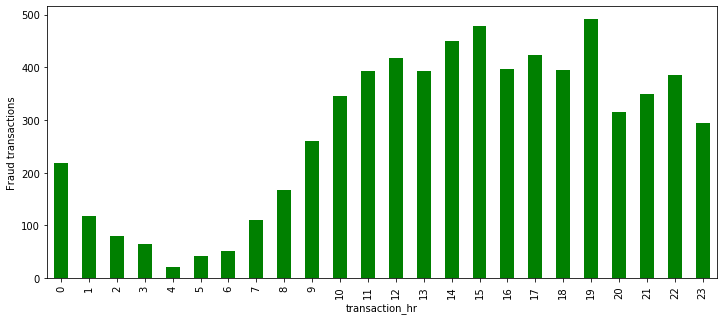

In [16]:
analyse_discrete(X_train,'transaction_hr')

From the above graph we can see that most of the fraud transactions are happening after 9:00AM. So we can create a new flag, which tells whether the transaction happened before or after 9:00AM.

In [17]:
# creating new feature to check if the transaction hour is greater than 9
X_train['hr_gt_nine'] = X_train['transaction_hr'].apply(lambda x: 1 if x > 9 else 0)  
X_test['hr_gt_nine'] = X_test['transaction_hr'].apply(lambda x: 1 if x > 9 else 0)

There are various types of financial crimes.

1. Structuring (smurfing): A method involving numerous transactions (deposits, withdrawals, transfers), often various people, high volumes of transactions and sometimes numerous accounts to avoid detection threshold reporting obligations.

2. Bust out: Here the hackers and thieves create accounts, make a large number of transactions until they are caught and locked out.

Sometimes the fraudsters do contionous transactions until they caught. So finding the average number of transactions per user might help us in detecting them.

Let's find the average number of transactions done by the customer per day.

In [18]:
def avg_trans_day(df):
    freq_trans_df = df.groupby(['user_id','transaction_date'])['transaction_id'].count()
    freq_trans_df = pd.DataFrame(freq_trans_df)
    freq_trans_df.reset_index(inplace = True)
    f = pd.DataFrame(freq_trans_df.groupby('user_id')['transaction_id'].mean())
    f.reset_index(inplace=True)
    f['transaction_id'] = f['transaction_id'].apply(np.int64)
    f['avg_transaction_count'] = f['transaction_id']
    f.drop(['transaction_id'],axis=1,inplace=True)
    df = pd.merge(f,df,on = 'user_id',how='inner')
    return df

In [19]:
X_train = avg_trans_day(X_train)
X_test = avg_trans_day(X_test)

In [20]:
def percentage_distribution(df,var):
    counter = df.groupby(var)['is_fraud'].value_counts().unstack()
    #calculate the % for each age group 
    percentage_dist = 100 * counter.divide(counter.sum(axis = 1), axis = 0)
    percentage_dist = percentage_dist[percentage_dist> 0]
    ax = percentage_dist.plot.bar(stacked=True,rot = 0,figsize = (15,5))
    plt.legend(bbox_to_anchor=(0, 1), loc='upper right', ncol=1)
    plt.ylabel('Fraud transactions')
    sns.set(font_scale=0.8)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy() 
        ax.text(x+width/2, 
                y+height/2, 
                '{:.0f} %'.format(height), 
                horizontalalignment='center', 
                verticalalignment='center')

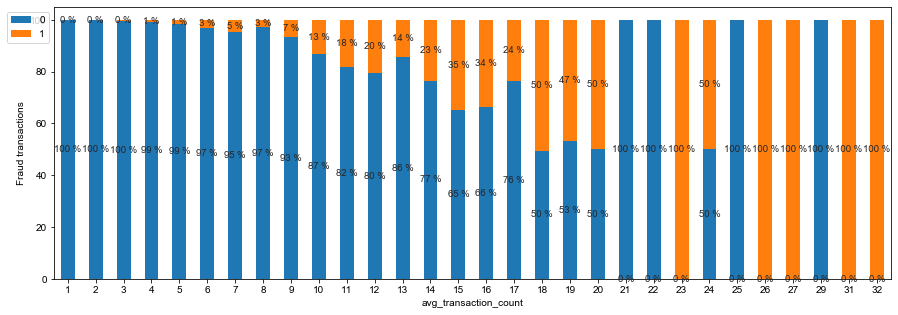

In [21]:
percentage_distribution(X_train,'avg_transaction_count')

As expected with the increase in average transaction count per day fraud transactions are also increasing.

Let's check whether customer age has any effect on the fraud's behaviour.

In [22]:
def calculate_age(born):
    #born = datetime.strptime(born, "%d.%m.%Y").date()
    today = date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [23]:
X_train['user_age'] = X_train['birth_date'].apply(calculate_age)
X_test['user_age'] = X_test['birth_date'].apply(calculate_age)

In [24]:
X_train['age'] = pd.cut(X_train['user_age'], range(18,100,10), labels=['18-27', '28-37', '38-47','48-57','58-67','68-77','78-87','88-97'])
X_test['age'] = pd.cut(X_test['user_age'], range(18,100,10), labels=['18-27', '28-37', '38-47','48-57','58-67','68-77','78-87','88-97'])

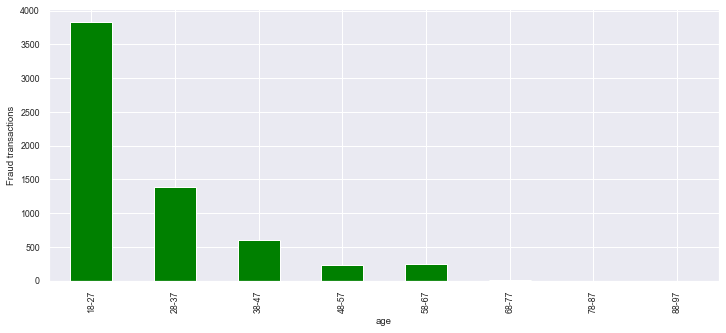

In [25]:
analyse_discrete(X_train,'age')

From the above graph we can infer that most of the fraud transactions are done by young people aged from 18-27. 

### Categorical variables : Remove rare labels.
<a id="remove_rares"></a>

First, we will remove those categories within variables that are present in less than 1% of the observations:

In [26]:
# let's capture the categorical variables first
cat_vars = ['state','currency','country','type','age']

In [27]:
def find_frequent_labels(df, var, rare_perc):
    # finds the labels that are shared by more than a certain % of the houses in the dataset
    df = df.copy()
    tmp = df.groupby(var)['is_fraud'].count() / len(df)
    return tmp[tmp>rare_perc].index

for var in cat_vars:
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], 'Rare')
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

In [28]:
for var in cat_vars:
    print(var, 'has',len(X_train[var].unique()), ' categories')

state has 4  categories
currency has 12  categories
country has 18  categories
type has 6  categories
age has 6  categories


Now we can have reduced the dimensions a lot. Usually data in high dimensions behaves wierdly.( It's proven that data in higher dimensional spaces lies on the outer crust of the surface and in these scenarios most of the exsiting ML algorithms would not work properly. To deal with this Persistent homology is gaining a lot of attention.)

### Categorical variables: convert strings to numbers
<a id="str_to_num"></a>

Next, we need to transform the strings of these variables into numbers.

In [29]:
one_hot_columns = cat_vars   # one hot encoding the categorical columns
X_train = pd.get_dummies(X_train,columns=one_hot_columns)
X_test = pd.get_dummies(X_test,columns=one_hot_columns)

In [30]:
X_train.head()

,user_id,avg_transaction_count,transaction_id,transaction_ts,amount_gbp,registered_ts,birth_date,is_fraud,transaction_hr,transaction_date,hr_gt_nine,user_age,state_COMPLETED,state_DECLINED,state_FAILED,state_REVERTED,currency_BGN,currency_CHF,currency_CZK,currency_EUR,currency_GBP,currency_HRK,currency_HUF,currency_PLN,currency_RON,currency_Rare,currency_SEK,currency_USD,country_BG,country_CH,country_CZ,country_DE,country_ES,country_FR,country_GB,country_HR,country_HU,country_IE,country_IT,country_LT,country_LV,country_PL,country_PT,country_RO,country_Rare,country_SE,type_ATM,type_CARD_PAYMENT,type_EXCHANGE,type_FEE,type_TOPUP,type_TRANSFER,age_18-27,age_28-37,age_38-47,age_48-57,age_58-67,age_Rare
0,00001f33-1d47-47a3-8955-e719172e788b,2,46285eca-e1b1-43a2-b8b0-c173b48f5a95,2019-04-21 11:04:53.081,46.89,2019-04-11 20:49:42.623,1994-08-17,0,11,2019-04-21,1,25,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
1,00001f33-1d47-47a3-8955-e719172e788b,2,1be7d138-fbaf-4216-8dc8-5056ec5f972c,2019-04-21 10:14:53.814,44.44,2019-04-11 20:49:42.623,1994-08-17,0,10,2019-04-21,1,25,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0
2,00001f33-1d47-47a3-8955-e719172e788b,2,a9aa681d-451e-44c5-8df0-687661ac583d,2019-04-19 21:05:53.192,115.84,2019-04-11 20:49:42.623,1994-08-17,0,21,2019-04-19,1,25,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
3,00001f33-1d47-47a3-8955-e719172e788b,2,e6021128-f4c1-4164-b3de-697e66ad613c,2019-04-11 20:55:20.996,5.34,2019-04-11 20:49:42.623,1994-08-17,0,20,2019-04-11,1,25,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
4,00001f33-1d47-47a3-8955-e719172e788b,2,9499c9c9-c9a9-410f-820d-c6e92fed27fb,2019-04-11 20:53:54.700,0.01,2019-04-11 20:49:42.623,1994-08-17,0,20,2019-04-11,1,25,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


### Feature Scaling
<a id="standardize"></a>

For use in linear models, features need to be either scaled or normalised.

In [31]:
train_vars = [var for var in X_train.columns if var not in ['user_id', 'transaction_id','transaction_ts','registered_ts','birth_date','transaction_date','user_age','is_fraud']]
len(train_vars)

50

In [32]:
# fit scaler
scaler = StandardScaler() # create an instance
scaler.fit(X_train[train_vars]) #  fit  the scaler to the train set for later use

# transform the train and test set, and add on the other variables
X_train = pd.concat([X_train[['user_id', 'transaction_id','transaction_ts','registered_ts','birth_date','transaction_date','user_age','is_fraud']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(X_train[train_vars]), columns=train_vars)],
                    axis=1)

X_test = pd.concat([X_test[['user_id', 'transaction_id','transaction_ts','registered_ts','birth_date','transaction_date','user_age','is_fraud']].reset_index(drop=True),
                    pd.DataFrame(scaler.transform(X_test[train_vars]), columns=train_vars)],
                    axis=1)

In [33]:
X_train.head()

,user_id,transaction_id,transaction_ts,registered_ts,birth_date,transaction_date,user_age,is_fraud,avg_transaction_count,amount_gbp,transaction_hr,hr_gt_nine,state_COMPLETED,state_DECLINED,state_FAILED,state_REVERTED,currency_BGN,currency_CHF,currency_CZK,currency_EUR,currency_GBP,currency_HRK,currency_HUF,currency_PLN,currency_RON,currency_Rare,currency_SEK,currency_USD,country_BG,country_CH,country_CZ,country_DE,country_ES,country_FR,country_GB,country_HR,country_HU,country_IE,country_IT,country_LT,country_LV,country_PL,country_PT,country_RO,country_Rare,country_SE,type_ATM,type_CARD_PAYMENT,type_EXCHANGE,type_FEE,type_TOPUP,type_TRANSFER,age_18-27,age_28-37,age_38-47,age_48-57,age_58-67,age_Rare
0,00001f33-1d47-47a3-8955-e719172e788b,46285eca-e1b1-43a2-b8b0-c173b48f5a95,2019-04-21 11:04:53.081,2019-04-11 20:49:42.623,1994-08-17,2019-04-21,25,0,-0.508167,0.054028,-0.580791,0.504333,0.727990,-0.250637,-0.331993,-0.481188,-0.112081,-0.174942,-0.138751,1.256661,-0.527487,-0.13125,-0.176167,-0.322369,-0.265881,-0.197194,-0.1061,-0.290565,-0.116779,-0.199412,-0.151228,-0.121195,-0.233889,-0.316005,-0.616132,-0.107685,-0.176442,3.487115,-0.133202,-0.122211,-0.115657,-0.386638,-0.211368,-0.290697,-0.272798,-0.10378,-0.136299,1.620741,-0.226587,-0.251627,-1.136748,-0.187375,1.370363,-0.639831,-0.482421,-0.347228,-0.200353,-0.166816
1,00001f33-1d47-47a3-8955-e719172e788b,1be7d138-fbaf-4216-8dc8-5056ec5f972c,2019-04-21 10:14:53.814,2019-04-11 20:49:42.623,1994-08-17,2019-04-21,25,0,-0.508167,0.043652,-0.778896,0.504333,0.727990,-0.250637,-0.331993,-0.481188,-0.112081,-0.174942,-0.138751,1.256661,-0.527487,-0.13125,-0.176167,-0.322369,-0.265881,-0.197194,-0.1061,-0.290565,-0.116779,-0.199412,-0.151228,-0.121195,-0.233889,-0.316005,-0.616132,-0.107685,-0.176442,3.487115,-0.133202,-0.122211,-0.115657,-0.386638,-0.211368,-0.290697,-0.272798,-0.10378,-0.136299,1.620741,-0.226587,-0.251627,-1.136748,-0.187375,1.370363,-0.639831,-0.482421,-0.347228,-0.200353,-0.166816
2,00001f33-1d47-47a3-8955-e719172e788b,a9aa681d-451e-44c5-8df0-687661ac583d,2019-04-19 21:05:53.192,2019-04-11 20:49:42.623,1994-08-17,2019-04-19,25,0,-0.508167,0.346044,1.400259,0.504333,0.727990,-0.250637,-0.331993,-0.481188,-0.112081,-0.174942,-0.138751,1.256661,-0.527487,-0.13125,-0.176167,-0.322369,-0.265881,-0.197194,-0.1061,-0.290565,-0.116779,-0.199412,-0.151228,-0.121195,-0.233889,-0.316005,-0.616132,-0.107685,-0.176442,3.487115,-0.133202,-0.122211,-0.115657,-0.386638,-0.211368,-0.290697,-0.272798,-0.10378,-0.136299,-0.617002,-0.226587,-0.251627,0.879702,-0.187375,1.370363,-0.639831,-0.482421,-0.347228,-0.200353,-0.166816
3,00001f33-1d47-47a3-8955-e719172e788b,e6021128-f4c1-4164-b3de-697e66ad613c,2019-04-11 20:55:20.996,2019-04-11 20:49:42.623,1994-08-17,2019-04-11,25,0,-0.508167,-0.121944,1.202154,0.504333,0.727990,-0.250637,-0.331993,-0.481188,-0.112081,-0.174942,-0.138751,1.256661,-0.527487,-0.13125,-0.176167,-0.322369,-0.265881,-0.197194,-0.1061,-0.290565,-0.116779,-0.199412,-0.151228,-0.121195,-0.233889,-0.316005,-0.616132,-0.107685,-0.176442,3.487115,-0.133202,-0.122211,-0.115657,-0.386638,-0.211368,-0.290697,-0.272798,-0.10378,-0.136299,-0.617002,-0.226587,3.974133,-1.136748,-0.187375,1.370363,-0.639831,-0.482421,-0.347228,-0.200353,-0.166816
4,00001f33-1d47-47a3-8955-e719172e788b,9499c9c9-c9a9-410f-820d-c6e92fed27fb,2019-04-11 20:53:54.700,2019-04-11 20:49:42.623,1994-08-17,2019-04-11,25,0,-0.508167,-0.144518,1.202154,0.504333,-1.373644,-0.250637,-0.331993,2.078191,-0.112081,-0.174942,-0.138751,1.256661,-0.527487,-0.13125,-0.176167,-0.322369,-0.265881,-0.197194,-0.1061,-0.290565,-0.116779,-0.199412,-0.151228,-0.121195,-0.233889,-0.316005,-0.616132,-0.107685,-0.176442,3.487115,-0.133202,-0.122211,-0.115657,-0.386638,-0.211368,-0.290697,-0.272798,-0.10378,-0.136299,-0.617002,-0.226587,-0.251627,0.879702,-0.187375,1.370363,-0.639831,-0.482421,-0.347228,-0.200353,-0.166816


In [34]:
# let's now save the train and test sets for the next notebook!

X_train.to_csv('../data/xtrain.csv', index=False)
X_test.to_csv('../data/xtest.csv', index=False)

### References

https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc

https://stats.stackexchange.com/questions/384833/adjusting-probability-threshold-for-sklearns-logistic-regression-model

https://github.com/trainindata/deploying-machine-learning-models

https://medium.com/datadriveninvestor/rethinking-the-right-metrics-for-fraud-detection-4edfb629c423